In [1]:
# Cell 1: Importing Required Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets, load_resampled_data
from model_utils import (
    initialize_all_models,
    train_single_model,
    evaluate_model_predictions,
    perform_cross_validation,
    save_trained_model
)
from evaluation_utils import (
    calculate_all_metrics,
    create_confusion_matrix,
    perform_statistical_significance_test,
    print_statistical_test_results,
    create_metrics_summary_table
)

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Random Seed: {SEED_VALUE}")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Random Seed: 42


In [2]:
# Cell 2: Load Test Data (Unchanged)
# Loading test data which remains constant across all experiments
# One thing to remember is that test set is NEVER resampled

print("="*70)
print("LOADING TEST DATA")
print("="*70)

# Loading original processed datasets
X_train_original, X_test, y_train_original, y_test = retrieve_processed_datasets(
    file_prefix='higgs'
)

print("\nTest set loaded (unchanged across all experiments):")
print(f"  Test features shape: {X_test.shape}")
print(f"  Test labels shape: {y_test.shape}")

# Displaying test set distribution
test_dist = y_test.value_counts().sort_index()
print(f"\nTest Set Class Distribution:")
for class_label, count in test_dist.items():
    percentage = (count / len(y_test)) * 100
    print(f"  Class {int(class_label)}: {count:,} ({percentage:.2f}%)")

print("\nNote: This test set will be used to evaluate ALL 55 experiments")

LOADING TEST DATA
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Test set loaded (unchanged across all experiments):
  Test features shape: (200000, 28)
  Test labels shape: (200000,)

Test Set Class Distribution:
  Class 0: 94,065 (47.03%)
  Class 1: 105,935 (52.97%)

Note: This test set will be used to evaluate ALL 55 experiments


In [3]:
# Cell 3: Load Baseline Results
# Purpose: Loading baseline performance for comparison

print("="*70)
print("LOADING BASELINE RESULTS")
print("="*70)

# Loading baseline metrics
baseline_metrics_path = METRIC_OUTPUT / 'baseline' / 'baseline_metrics.json'

with open(baseline_metrics_path, 'r', encoding='utf-8') as f:
    baseline_metrics = json.load(f)

print("\nBaseline metrics loaded successfully!")
print(f"Number of baseline models: {len(baseline_metrics)}")

# Displaying baseline F1-scores
print("\nBaseline F1-Scores (No Resampling):")
for model_name, metrics in baseline_metrics.items():
    print(f"  {model_name.replace('_', ' ').title()}: {metrics['f1_score']:.4f}")

# Identifying best baseline
best_baseline_model = max(baseline_metrics.items(), 
                          key=lambda x: x[1]['f1_score'])
print(f"\nBest Baseline: {best_baseline_model[0]} (F1={best_baseline_model[1]['f1_score']:.4f})")

LOADING BASELINE RESULTS

Baseline metrics loaded successfully!
Number of baseline models: 5

Baseline F1-Scores (No Resampling):
  Logistic Regression: 0.6869
  Random Forest: 0.7493
  Xgboost: 0.7468
  Svm: 0.4500
  Mlp: 0.7701

Best Baseline: mlp (F1=0.7701)


In [4]:
# Cell 4: Load Resampling Statistics
# Loading resampling method information from previous notebook (03) 
# Statistics for each resampling method

print("="*70)
print("LOADING RESAMPLING STATISTICS")
print("="*70)

# Loading resampling statistics
resampling_stats_path = METRIC_OUTPUT / 'resampling' / 'resampling_statistics.json'

with open(resampling_stats_path, 'r', encoding='utf-8') as f:
    resampling_stats = json.load(f)

print("\nResampling statistics loaded successfully!")
print(f"Number of resampling methods: {len(resampling_stats)}")

print("\nResampling Methods Available:")
for i, method_name in enumerate(resampling_stats.keys(), 1):
    method_info = resampling_stats[method_name]
    print(f"  {i:2d}. {method_name.replace('_', ' ').title()}: "
          f"{method_info['n_samples']:,} samples "
          f"(Ratio: {method_info['imbalance_ratio']:.3f}:1)")


LOADING RESAMPLING STATISTICS

Resampling statistics loaded successfully!
Number of resampling methods: 11

Resampling Methods Available:
   1. Baseline: 800,000 samples (Ratio: 0.888:1)
   2. Random Oversampling: 847,476 samples (Ratio: 1.000:1)
   3. Smote: 847,476 samples (Ratio: 1.000:1)
   4. Borderline Smote: 847,476 samples (Ratio: 1.000:1)
   5. Adasyn: 847,476 samples (Ratio: 1.000:1)
   6. Random Undersampling: 752,524 samples (Ratio: 1.000:1)
   7. Tomek Links: 751,637 samples (Ratio: 0.998:1)
   8. Nearmiss: 752,524 samples (Ratio: 1.000:1)
   9. Smote Tomek: 771,632 samples (Ratio: 1.000:1)
  10. Smote Enn: 276,095 samples (Ratio: 0.858:1)
  11. Class Weighting: 800,000 samples (Ratio: 0.888:1)


In [5]:
# Cell 5: Defining Experiment Configuration
# Setting up experimental design and tracking structure
# Experiment matrix and results storage

print("="*70)
print("EXPERIMENT CONFIGURATION")
print("="*70)

# Defining resampling methods to test
resampling_methods = list(resampling_stats.keys())

# Defining models to test
model_names = ['logistic_regression', 'random_forest', 'xgboost', 'svm', 'mlp']

# Computing total experiments
total_experiments = len(resampling_methods) * len(model_names)

print(f"\nExperimental Design:")
print(f"  Resampling Methods: {len(resampling_methods)}")
print(f"  ML Models: {len(model_names)}")
print(f"  Total Experiments: {total_experiments}")
print(f"  Cross-Validation Folds: {FOLD_COUNT}")
print(f"  Total Model Trainings: {total_experiments * FOLD_COUNT}")

print(f"\nResampling Methods:")
for method in resampling_methods:
    print(f"  - {method}")

print(f"\nML Models:")
for model in model_names:
    print(f"  - {model}")

# Initializing results storage
experiment_results = []

print("\nExperiment tracking initialized")

EXPERIMENT CONFIGURATION

Experimental Design:
  Resampling Methods: 11
  ML Models: 5
  Total Experiments: 55
  Cross-Validation Folds: 5
  Total Model Trainings: 275

Resampling Methods:
  - baseline
  - random_oversampling
  - smote
  - borderline_smote
  - adasyn
  - random_undersampling
  - tomek_links
  - nearmiss
  - smote_tomek
  - smote_enn
  - class_weighting

ML Models:
  - logistic_regression
  - random_forest
  - xgboost
  - svm
  - mlp

Experiment tracking initialized


In [6]:
# Cell 6: Main Experiment Loop - Part 1 (Baseline + ROS + SMOTE)
# Running first 3 resampling methods × 5 models = 15 experiments
# Methods: baseline, random_oversampling, smote


print("="*70)
print("STARTING MAIN EXPERIMENTS - PART 1")
print("="*70)
print("Processing: Baseline, Random Oversampling, SMOTE")
print(f"Experiments in this batch: 15")
print("="*70)

# Methods for this batch
batch_1_methods = ['baseline', 'random_oversampling', 'smote']

experiment_counter = 0

for method_name in batch_1_methods:
    print(f"\n{'='*70}")
    print(f"RESAMPLING METHOD: {method_name.upper()}")
    print(f"{'='*70}")
    
    # Loading resampled data
    if method_name == 'class_weighting':
        # Class weighting uses original data
        X_resampled = X_train_original.copy()
        y_resampled = y_train_original.copy()
        use_weights = True
        class_weights = resampling_stats[method_name].get('weights', None)
    else:
        # Loading resampled dataset
        X_resampled, y_resampled = load_resampled_data(
            method_name=method_name,
            data_dir=RESAMPLED_DIR
        )
        use_weights = False
        class_weights = None
    
    print(f"\nDataset loaded: {len(X_resampled):,} samples")
    
    # Training all models on this resampled data
    for model_name in model_names:
        experiment_counter += 1
        
        print(f"\n{'-'*70}")
        print(f"Experiment {experiment_counter}/{total_experiments}: "
              f"{method_name} + {model_name}")
        print(f"{'-'*70}")
        
        # Recording experiment start time
        exp_start_time = time.time()
        
        try:
            # Initializing model
            models = initialize_all_models(
                use_class_weights=use_weights,
                class_weight_dict=class_weights
            )
            model = models[model_name]
            
            # Training model
            trained_model, train_time = train_single_model(
                model=model,
                X_train=X_resampled,
                y_train=y_resampled,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            # Evaluating on test set
            eval_results = evaluate_model_predictions(
                model=trained_model,
                X_test=X_test,
                y_test=y_test,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            # Computing metrics
            metrics = calculate_all_metrics(
                y_true=y_test,
                y_pred=eval_results['y_pred'],
                y_proba=eval_results['y_proba']
            )
            
            # Computing total experiment time
            exp_time = time.time() - exp_start_time
            
            # Storing results
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr'],
                'g_mean': metrics['g_mean'],
                'mcc': metrics['mcc'],
                'training_time': train_time,
                'experiment_time': exp_time,
                'dataset_size': len(X_resampled),
                'status': 'success'
            }
            
            experiment_results.append(result_row)
            
            print(f"Status: SUCCESS")
            print(f"F1-Score: {metrics['f1_score']:.4f}")
            print(f"Time: {exp_time:.2f}s")
            
        except Exception as e:
            print(f"Status: FAILED - {str(e)}")
            
            # Recording failure
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'status': 'failed',
                'error': str(e)
            }
            experiment_results.append(result_row)

print(f"\n{'='*70}")
print(f"BATCH 1 COMPLETED: {experiment_counter}/{total_experiments} experiments")
print(f"{'='*70}")

STARTING MAIN EXPERIMENTS - PART 1
Processing: Baseline, Random Oversampling, SMOTE
Experiments in this batch: 15

RESAMPLING METHOD: BASELINE
Loading resampled data: baseline
  Loaded 800,000 samples
  Features shape: (800000, 28)

Dataset loaded: 800,000 samples

----------------------------------------------------------------------
Experiment 1/55: baseline + logistic_regression
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.6869
Time: 3.63s

----------------------------------------------------------------------
Experiment 2/55: baseline + random_forest
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7493
Time: 77.58s

----------------------------------------------------------------------
Experiment 3/55: baseline + xgboost
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7468
Time: 4.08s

-------------------------------------------

In [7]:
# Cell 7: Main Experiment Loop - Part 2 (Borderline-SMOTE + ADASYN)
# Running next 2 resampling methods × 5 models = 10 experiments
# Methods: borderline_smote, adasyn

print("="*70)
print("STARTING MAIN EXPERIMENTS - PART 2")
print("="*70)
print("Processing: Borderline-SMOTE, ADASYN")
print(f"Experiments in this batch: 10")
print("="*70)

# Methods for this batch
batch_2_methods = ['borderline_smote', 'adasyn']

for method_name in batch_2_methods:
    print(f"\n{'='*70}")
    print(f"RESAMPLING METHOD: {method_name.upper()}")
    print(f"{'='*70}")
    
    # Loading resampled data
    X_resampled, y_resampled = load_resampled_data(
        method_name=method_name,
        data_dir=RESAMPLED_DIR
    )
    
    print(f"\nDataset loaded: {len(X_resampled):,} samples")
    
    # Training all models
    for model_name in model_names:
        experiment_counter += 1
        
        print(f"\n{'-'*70}")
        print(f"Experiment {experiment_counter}/{total_experiments}: "
              f"{method_name} + {model_name}")
        print(f"{'-'*70}")
        
        exp_start_time = time.time()
        
        try:
            models = initialize_all_models(use_class_weights=False)
            model = models[model_name]
            
            trained_model, train_time = train_single_model(
                model=model,
                X_train=X_resampled,
                y_train=y_resampled,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            eval_results = evaluate_model_predictions(
                model=trained_model,
                X_test=X_test,
                y_test=y_test,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            metrics = calculate_all_metrics(
                y_true=y_test,
                y_pred=eval_results['y_pred'],
                y_proba=eval_results['y_proba']
            )
            
            exp_time = time.time() - exp_start_time
            
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr'],
                'g_mean': metrics['g_mean'],
                'mcc': metrics['mcc'],
                'training_time': train_time,
                'experiment_time': exp_time,
                'dataset_size': len(X_resampled),
                'status': 'success'
            }
            
            experiment_results.append(result_row)
            
            print(f"Status: SUCCESS")
            print(f"F1-Score: {metrics['f1_score']:.4f}")
            print(f"Time: {exp_time:.2f}s")
            
        except Exception as e:
            print(f"Status: FAILED - {str(e)}")
            
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'status': 'failed',
                'error': str(e)
            }
            experiment_results.append(result_row)

print(f"\n{'='*70}")
print(f"BATCH 2 COMPLETED: {experiment_counter}/{total_experiments} experiments")
print(f"{'='*70}")

STARTING MAIN EXPERIMENTS - PART 2
Processing: Borderline-SMOTE, ADASYN
Experiments in this batch: 10

RESAMPLING METHOD: BORDERLINE_SMOTE
Loading resampled data: borderline_smote
  Loaded 847,476 samples
  Features shape: (847476, 28)

Dataset loaded: 847,476 samples

----------------------------------------------------------------------
Experiment 16/55: borderline_smote + logistic_regression
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.6569
Time: 9.44s

----------------------------------------------------------------------
Experiment 17/55: borderline_smote + random_forest
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7382
Time: 77.00s

----------------------------------------------------------------------
Experiment 18/55: borderline_smote + xgboost
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7364
Time: 3.65s

------------

In [8]:
# Cell 8: Main Experiment Loop - Part 3 (Undersampling Methods)
# Running 3 undersampling methods × 5 models = 15 experiments
# Methods: random_undersampling, tomek_links, nearmiss

print("="*70)
print("STARTING MAIN EXPERIMENTS - PART 3")
print("="*70)
print("Processing: Random Undersampling, Tomek Links, NearMiss")
print(f"Experiments in this batch: 15")
print("="*70)

# Methods for this batch
batch_3_methods = ['random_undersampling', 'tomek_links', 'nearmiss']

for method_name in batch_3_methods:
    print(f"\n{'='*70}")
    print(f"RESAMPLING METHOD: {method_name.upper()}")
    print(f"{'='*70}")
    
    # Loading resampled data
    X_resampled, y_resampled = load_resampled_data(
        method_name=method_name,
        data_dir=RESAMPLED_DIR
    )
    
    print(f"\nDataset loaded: {len(X_resampled):,} samples")
    
    # Training all models
    for model_name in model_names:
        experiment_counter += 1
        
        print(f"\n{'-'*70}")
        print(f"Experiment {experiment_counter}/{total_experiments}: "
              f"{method_name} + {model_name}")
        print(f"{'-'*70}")
        
        exp_start_time = time.time()
        
        try:
            models = initialize_all_models(use_class_weights=False)
            model = models[model_name]
            
            trained_model, train_time = train_single_model(
                model=model,
                X_train=X_resampled,
                y_train=y_resampled,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            eval_results = evaluate_model_predictions(
                model=trained_model,
                X_test=X_test,
                y_test=y_test,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            metrics = calculate_all_metrics(
                y_true=y_test,
                y_pred=eval_results['y_pred'],
                y_proba=eval_results['y_proba']
            )
            
            exp_time = time.time() - exp_start_time
            
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr'],
                'g_mean': metrics['g_mean'],
                'mcc': metrics['mcc'],
                'training_time': train_time,
                'experiment_time': exp_time,
                'dataset_size': len(X_resampled),
                'status': 'success'
            }
            
            experiment_results.append(result_row)
            
            print(f"Status: SUCCESS")
            print(f"F1-Score: {metrics['f1_score']:.4f}")
            print(f"Time: {exp_time:.2f}s")
            
        except Exception as e:
            print(f"Status: FAILED - {str(e)}")
            
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'status': 'failed',
                'error': str(e)
            }
            experiment_results.append(result_row)

print(f"\n{'='*70}")
print(f"BATCH 3 COMPLETED: {experiment_counter}/{total_experiments} experiments")
print(f"{'='*70}")

STARTING MAIN EXPERIMENTS - PART 3
Processing: Random Undersampling, Tomek Links, NearMiss
Experiments in this batch: 15

RESAMPLING METHOD: RANDOM_UNDERSAMPLING
Loading resampled data: random_undersampling
  Loaded 752,524 samples
  Features shape: (752524, 28)

Dataset loaded: 752,524 samples

----------------------------------------------------------------------
Experiment 26/55: random_undersampling + logistic_regression
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.6610
Time: 3.39s

----------------------------------------------------------------------
Experiment 27/55: random_undersampling + random_forest
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7388
Time: 65.44s

----------------------------------------------------------------------
Experiment 28/55: random_undersampling + xgboost
----------------------------------------------------------------------
Status: SUCCESS
F1-

In [9]:
# Cell 9: Main Experiment Loop - Part 4 (Combination Methods + Class Weights)
# Purpose: Running final 3 methods × 5 models = 15 experiments
# Methods: smote_tomek, smote_enn, class_weighting
# ============================================================================

print("="*70)
print("STARTING MAIN EXPERIMENTS - PART 4 (FINAL BATCH)")
print("="*70)
print("Processing: SMOTE+Tomek, SMOTE+ENN, Class Weighting")
print(f"Experiments in this batch: 15")
print("="*70)

# Methods for this batch
batch_4_methods = ['smote_tomek', 'smote_enn', 'class_weighting']

for method_name in batch_4_methods:
    print(f"\n{'='*70}")
    print(f"RESAMPLING METHOD: {method_name.upper()}")
    print(f"{'='*70}")
    
    # Loading resampled data
    if method_name == 'class_weighting':
        X_resampled = X_train_original.copy()
        y_resampled = y_train_original.copy()
        use_weights = True
        class_weights = resampling_stats[method_name].get('weights', None)
    else:
        X_resampled, y_resampled = load_resampled_data(
            method_name=method_name,
            data_dir=RESAMPLED_DIR
        )
        use_weights = False
        class_weights = None
    
    print(f"\nDataset loaded: {len(X_resampled):,} samples")
    
    # Training all models
    for model_name in model_names:
        experiment_counter += 1
        
        print(f"\n{'-'*70}")
        print(f"Experiment {experiment_counter}/{total_experiments}: "
              f"{method_name} + {model_name}")
        print(f"{'-'*70}")
        
        exp_start_time = time.time()
        
        try:
            models = initialize_all_models(
                use_class_weights=use_weights,
                class_weight_dict=class_weights
            )
            model = models[model_name]
            
            trained_model, train_time = train_single_model(
                model=model,
                X_train=X_resampled,
                y_train=y_resampled,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            eval_results = evaluate_model_predictions(
                model=trained_model,
                X_test=X_test,
                y_test=y_test,
                model_name=f"{method_name}_{model_name}",
                verbose=False
            )
            
            metrics = calculate_all_metrics(
                y_true=y_test,
                y_pred=eval_results['y_pred'],
                y_proba=eval_results['y_proba']
            )
            
            exp_time = time.time() - exp_start_time
            
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'auc_roc': metrics['auc_roc'],
                'auc_pr': metrics['auc_pr'],
                'g_mean': metrics['g_mean'],
                'mcc': metrics['mcc'],
                'training_time': train_time,
                'experiment_time': exp_time,
                'dataset_size': len(X_resampled),
                'status': 'success'
            }
            
            experiment_results.append(result_row)
            
            print(f"Status: SUCCESS")
            print(f"F1-Score: {metrics['f1_score']:.4f}")
            print(f"Time: {exp_time:.2f}s")
            
        except Exception as e:
            print(f"Status: FAILED - {str(e)}")
            
            result_row = {
                'resampling_method': method_name,
                'model': model_name,
                'status': 'failed',
                'error': str(e)
            }
            experiment_results.append(result_row)

print(f"\n{'='*70}")
print(f"ALL EXPERIMENTS COMPLETED: {experiment_counter}/{total_experiments}")
print(f"{'='*70}")

STARTING MAIN EXPERIMENTS - PART 4 (FINAL BATCH)
Processing: SMOTE+Tomek, SMOTE+ENN, Class Weighting
Experiments in this batch: 15

RESAMPLING METHOD: SMOTE_TOMEK
Loading resampled data: smote_tomek
  Loaded 771,632 samples
  Features shape: (771632, 28)

Dataset loaded: 771,632 samples

----------------------------------------------------------------------
Experiment 41/55: smote_tomek + logistic_regression
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.6612
Time: 3.48s

----------------------------------------------------------------------
Experiment 42/55: smote_tomek + random_forest
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7406
Time: 69.86s

----------------------------------------------------------------------
Experiment 43/55: smote_tomek + xgboost
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7392
Time: 3.39s

--------

In [10]:
# Cell 9b: Re-runnig Failed Class Weighting Experiments
# Fixing the 3 failed class_weighting experiments

print("="*70)
print("RE-RUNNING FAILED CLASS WEIGHTING EXPERIMENTS")
print("="*70)

# Loading original training data
X_resampled = X_train_original.copy()
y_resampled = y_train_original.copy()

# Recalculating class weights with correct integer keys
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_original)
weights = compute_class_weight('balanced', classes=classes, y=y_train_original)
class_weights = dict(zip(classes, weights))

print(f"\nClass weights: {class_weights}")
print(f"Dataset: {len(X_resampled):,} samples")

# Models that failed
failed_models = ['logistic_regression', 'random_forest', 'svm']

for model_name in failed_models:
    print(f"\n{'-'*70}")
    print(f"Re-running: class_weighting + {model_name}")
    print(f"{'-'*70}")
    
    exp_start_time = time.time()
    
    try:
        # Initialize model with class weights
        models = initialize_all_models(
            use_class_weights=True,
            class_weight_dict=class_weights
        )
        model = models[model_name]
        
        # Train
        trained_model, train_time = train_single_model(
            model=model,
            X_train=X_resampled,
            y_train=y_resampled,
            model_name=f"class_weighting_{model_name}",
            verbose=False
        )
        
        # Evaluate
        eval_results = evaluate_model_predictions(
            model=trained_model,
            X_test=X_test,
            y_test=y_test,
            model_name=f"class_weighting_{model_name}",
            verbose=False
        )
        
        # Metrics
        metrics = calculate_all_metrics(
            y_true=y_test,
            y_pred=eval_results['y_pred'],
            y_proba=eval_results['y_proba']
        )
        
        exp_time = time.time() - exp_start_time
        
        # Update the failed result in experiment_results
        for i, result in enumerate(experiment_results):
            if (result['resampling_method'] == 'class_weighting' and 
                result['model'] == model_name and 
                result.get('status') == 'failed'):
                
                # Replace failed result with successful one
                experiment_results[i] = {
                    'resampling_method': 'class_weighting',
                    'model': model_name,
                    'accuracy': metrics['accuracy'],
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'f1_score': metrics['f1_score'],
                    'auc_roc': metrics['auc_roc'],
                    'auc_pr': metrics['auc_pr'],
                    'g_mean': metrics['g_mean'],
                    'mcc': metrics['mcc'],
                    'training_time': train_time,
                    'experiment_time': exp_time,
                    'dataset_size': len(X_resampled),
                    'status': 'success'
                }
                break
        
        print(f"Status: SUCCESS")
        print(f"F1-Score: {metrics['f1_score']:.4f}")
        print(f"Time: {exp_time:.2f}s")
        
    except Exception as e:
        print(f"Status: STILL FAILED - {str(e)}")

print(f"\n{'='*70}")
print("CLASS WEIGHTING EXPERIMENTS FIXED!")
print(f"{'='*70}")

RE-RUNNING FAILED CLASS WEIGHTING EXPERIMENTS

Class weights: {np.int64(0): np.float64(1.063089017758902), np.int64(1): np.float64(0.9439795345236915)}
Dataset: 800,000 samples

----------------------------------------------------------------------
Re-running: class_weighting + logistic_regression
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.6608
Time: 3.80s

----------------------------------------------------------------------
Re-running: class_weighting + random_forest
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.7430
Time: 71.76s

----------------------------------------------------------------------
Re-running: class_weighting + svm
----------------------------------------------------------------------
Status: SUCCESS
F1-Score: 0.0000
Time: 1137.79s

CLASS WEIGHTING EXPERIMENTS FIXED!


In [12]:
# Cell 10: Creating Results DataFrame
# Converting experiment results to organized DataFrame
# Complete results table with all experiments

print("="*70)
print("AGGREGATING EXPERIMENT RESULTS")
print("="*70)

# Creating DataFrame from results
results_df = pd.DataFrame(experiment_results)

# Filtering successful experiments
successful_df = results_df[results_df['status'] == 'success'].copy()
failed_df = results_df[results_df['status'] == 'failed'].copy()

print(f"\nExperiment Summary:")
print(f"  Total Experiments: {len(results_df)}")
print(f"  Successful: {len(successful_df)}")
print(f"  Failed: {len(failed_df)}")

if len(failed_df) > 0:
    print(f"\nFailed Experiments:")
    for idx, row in failed_df.iterrows():
        print(f"  - {row['resampling_method']} + {row['model']}: {row.get('error', 'Unknown')}")

# Displaying first few results
print(f"\nFirst 10 Experiment Results:")
print(successful_df[['resampling_method', 'model', 'f1_score', 'accuracy', 
                     'training_time']].head(10).to_string(index=False))

# Computing summary statistics
print(f"\nPerformance Statistics (F1-Score):")
print(f"  Mean: {successful_df['f1_score'].mean():.4f}")
print(f"  Std Dev: {successful_df['f1_score'].std():.4f}")
print(f"  Min: {successful_df['f1_score'].min():.4f}")
print(f"  Max: {successful_df['f1_score'].max():.4f}")
print(f"  Range: {successful_df['f1_score'].max() - successful_df['f1_score'].min():.4f}")

AGGREGATING EXPERIMENT RESULTS

Experiment Summary:
  Total Experiments: 55
  Successful: 55
  Failed: 0

First 10 Experiment Results:
  resampling_method               model  f1_score  accuracy  training_time
           baseline logistic_regression    0.6869    0.6414         3.4620
           baseline       random_forest    0.7493    0.7318        75.5978
           baseline             xgboost    0.7468    0.7303         3.7375
           baseline                 svm    0.4500    0.5343      1176.7481
           baseline                 mlp    0.7701    0.7546       236.2056
random_oversampling logistic_regression    0.6609    0.6385         3.5439
random_oversampling       random_forest    0.7431    0.7320        78.8454
random_oversampling             xgboost    0.7374    0.7297         4.2793
random_oversampling                 svm    0.5513    0.5531      1239.4197
random_oversampling                 mlp    0.7628    0.7516       181.9932

Performance Statistics (F1-Score):
  Me

In [13]:
# Cell 11: Identifying Top Performers
# Finding best model-resampling combinations
# Top 10 configurations by F1-score

print("="*70)
print("TOP PERFORMING CONFIGURATIONS")
print("="*70)

# Sorting by F1-score
top_performers = successful_df.nlargest(10, 'f1_score')[
    ['resampling_method', 'model', 'f1_score', 'accuracy', 'precision', 
     'recall', 'auc_roc']
].copy()

# Formatting method and model names
top_performers['resampling_method'] = top_performers['resampling_method'].str.replace('_', ' ').str.title()
top_performers['model'] = top_performers['model'].str.replace('_', ' ').str.title()

print("\nTop 10 Configurations by F1-Score:")
print(top_performers.to_string(index=False))

# Identifying absolute best
best_config = successful_df.nlargest(1, 'f1_score').iloc[0]
print(f"\nBest Overall Configuration:")
print(f"  Resampling: {best_config['resampling_method']}")
print(f"  Model: {best_config['model']}")
print(f"  F1-Score: {best_config['f1_score']:.4f}")
print(f"  Accuracy: {best_config['accuracy']:.4f}")
print(f"  AUC-ROC: {best_config['auc_roc']:.4f}")

# Comparing to baseline
baseline_best_f1 = best_baseline_model[1]['f1_score']
improvement = best_config['f1_score'] - baseline_best_f1
improvement_pct = (improvement / baseline_best_f1) * 100

print(f"\nImprovement over Baseline:")
print(f"  Baseline Best: {baseline_best_f1:.4f}")
print(f"  Resampled Best: {best_config['f1_score']:.4f}")
print(f"  Absolute Improvement: +{improvement:.4f}")
print(f"  Relative Improvement: +{improvement_pct:.2f}%")

TOP PERFORMING CONFIGURATIONS

Top 10 Configurations by F1-Score:
   resampling_method         model  f1_score  accuracy  precision  recall  auc_roc
            Baseline           Mlp    0.7701    0.7546     0.7644  0.7758   0.8378
     Class Weighting           Mlp    0.7701    0.7546     0.7644  0.7758   0.8378
         Smote Tomek           Mlp    0.7633    0.7525     0.7734  0.7535   0.8357
 Random Oversampling           Mlp    0.7628    0.7516     0.7717  0.7540   0.8360
Random Undersampling           Mlp    0.7624    0.7522     0.7746  0.7507   0.8362
         Tomek Links           Mlp    0.7603    0.7514     0.7768  0.7445   0.8349
    Borderline Smote           Mlp    0.7603    0.7515     0.7772  0.7441   0.8354
               Smote           Mlp    0.7592    0.7501     0.7754  0.7436   0.8345
              Adasyn           Mlp    0.7592    0.7501     0.7754  0.7436   0.8345
            Baseline Random Forest    0.7493    0.7318     0.7420  0.7568   0.8130

Best Overall Configu

In [14]:
# Cell 12: Performance by Resampling Method
# Analyzing which resampling methods work best overall
# Average performance for each resampling method

print("="*70)
print("PERFORMANCE BY RESAMPLING METHOD")
print("="*70)

# Grouping by resampling method
method_performance = successful_df.groupby('resampling_method').agg({
    'f1_score': ['mean', 'std', 'min', 'max'],
    'accuracy': 'mean',
    'auc_roc': 'mean',
    'training_time': 'mean'
}).round(4)

# Flattening column names
method_performance.columns = ['_'.join(col).strip() for col in method_performance.columns]
method_performance = method_performance.reset_index()

# Sorting by mean F1-score
method_performance = method_performance.sort_values('f1_score_mean', ascending=False)

print("\nAverage Performance by Resampling Method:")
print(method_performance[['resampling_method', 'f1_score_mean', 'f1_score_std',
                          'accuracy_mean', 'auc_roc_mean']].to_string(index=False))

# Identifying best method
best_method = method_performance.iloc[0]
print(f"\nBest Resampling Method (Average):")
print(f"  Method: {best_method['resampling_method']}")
print(f"  Mean F1-Score: {best_method['f1_score_mean']:.4f} (+/- {best_method['f1_score_std']:.4f})")

PERFORMANCE BY RESAMPLING METHOD

Average Performance by Resampling Method:
   resampling_method  f1_score_mean  f1_score_std  accuracy_mean  auc_roc_mean
    borderline_smote         0.7032        0.0591         0.6826        0.7449
           smote_enn         0.6936        0.0410         0.6752        0.7397
 random_oversampling         0.6911        0.0872         0.6810        0.7444
               smote         0.6894        0.0887         0.6851        0.7523
              adasyn         0.6894        0.0887         0.6851        0.7523
         tomek_links         0.6860        0.0886         0.6778        0.7422
random_undersampling         0.6847        0.0976         0.6802        0.7456
            nearmiss         0.6834        0.0659         0.6677        0.6958
            baseline         0.6806        0.1326         0.6785        0.7447
         smote_tomek         0.6669        0.1378         0.6763        0.7412
     class_weighting         0.5841        0.3292      

In [15]:
# Cell 13: Performance by Model Type
# Analyzing which models perform best across resampling methods
# Average performance for each model

print("="*70)
print("PERFORMANCE BY MODEL TYPE")
print("="*70)

# Grouping by model
model_performance = successful_df.groupby('model').agg({
    'f1_score': ['mean', 'std', 'min', 'max'],
    'accuracy': 'mean',
    'auc_roc': 'mean',
    'training_time': 'mean'
}).round(4)

# Flattening column names
model_performance.columns = ['_'.join(col).strip() for col in model_performance.columns]
model_performance = model_performance.reset_index()

# Sorting by mean F1-score
model_performance = model_performance.sort_values('f1_score_mean', ascending=False)

print("\nAverage Performance by Model:")
print(model_performance[['model', 'f1_score_mean', 'f1_score_std',
                        'accuracy_mean', 'training_time_mean']].to_string(index=False))

# Identifying best model
best_model_overall = model_performance.iloc[0]
print(f"\nBest Model (Average):")
print(f"  Model: {best_model_overall['model']}")
print(f"  Mean F1-Score: {best_model_overall['f1_score_mean']:.4f} (+/- {best_model_overall['f1_score_std']:.4f})")

PERFORMANCE BY MODEL TYPE

Average Performance by Model:
              model  f1_score_mean  f1_score_std  accuracy_mean  training_time_mean
                mlp         0.7575        0.0131         0.7477            179.9097
      random_forest         0.7372        0.0098         0.7282             65.9846
            xgboost         0.7360        0.0090         0.7268              3.1122
logistic_regression         0.6615        0.0108         0.6380              3.7903
                svm         0.4952        0.1766         0.5478           1054.5146

Best Model (Average):
  Model: mlp
  Mean F1-Score: 0.7575 (+/- 0.0131)


Generating performance heatmap...
Heatmap saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\experiment_heatmap_f1.png


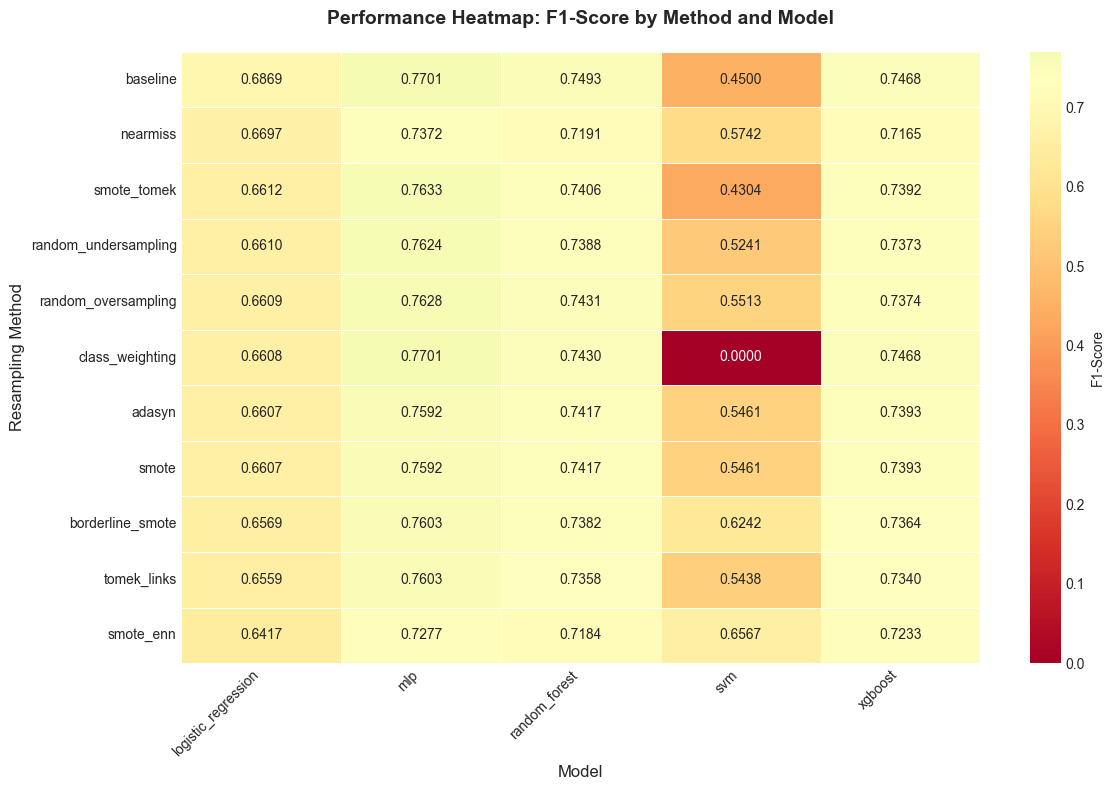

In [16]:
# Cell 14: Creating Performance Heatmap (F1-Score)
# Visualizing all 55 experiments as heatmap
# 11×5 heatmap showing F1-scores

print("Generating performance heatmap...")

# Creating pivot table for heatmap
heatmap_data = successful_df.pivot_table(
    values='f1_score',
    index='resampling_method',
    columns='model',
    aggfunc='mean'
)

# Sorting for better visualization
heatmap_data = heatmap_data.sort_values(by=heatmap_data.columns[0], ascending=False)

# Creating figure
fig, ax = plt.subplots(figsize=(12, 8))

# Creating heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn', 
            center=successful_df['f1_score'].median(),
            linewidths=0.5, cbar_kws={'label': 'F1-Score'},
            ax=ax)

# Formatting
ax.set_title('Performance Heatmap: F1-Score by Method and Model', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Resampling Method', fontsize=12)

# Rotating labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Saving
heatmap_path = FIGURE_OUTPUT / 'experiment_heatmap_f1.png'
plt.savefig(heatmap_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Heatmap saved to {heatmap_path}")

plt.show()

Generating AUC-ROC heatmap...
AUC-ROC heatmap saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\experiment_heatmap_auc.png


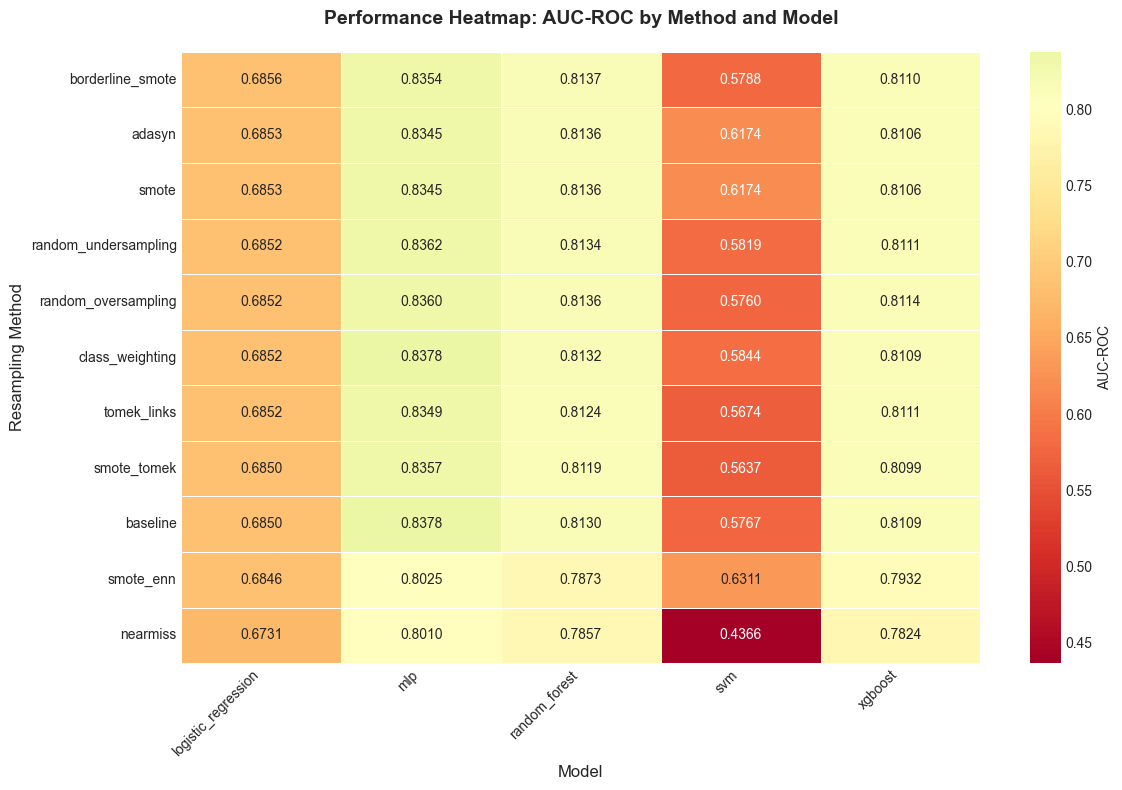

In [17]:
# Cell 15: Creating Performance Heatmap (AUC-ROC)
# Visualizing experiments by AUC-ROC score
# 11×5 heatmap showing AUC-ROC

print("Generating AUC-ROC heatmap...")

# Creating pivot table
auc_heatmap_data = successful_df.pivot_table(
    values='auc_roc',
    index='resampling_method',
    columns='model',
    aggfunc='mean'
)

# Sorting
auc_heatmap_data = auc_heatmap_data.sort_values(by=auc_heatmap_data.columns[0], 
                                                 ascending=False)

# Creating figure
fig, ax = plt.subplots(figsize=(12, 8))

# Creating heatmap
sns.heatmap(auc_heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn',
            center=successful_df['auc_roc'].median(),
            linewidths=0.5, cbar_kws={'label': 'AUC-ROC'},
            ax=ax)

# Formatting
ax.set_title('Performance Heatmap: AUC-ROC by Method and Model',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Resampling Method', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Saving
auc_heatmap_path = FIGURE_OUTPUT / 'experiment_heatmap_auc.png'
plt.savefig(auc_heatmap_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"AUC-ROC heatmap saved to {auc_heatmap_path}")

plt.show()

In [18]:
# Cell 16: Best Method for Each Model
# Identifying optimal resampling method for each model
# Best configuration for each of 5 models

print("="*70)
print("BEST RESAMPLING METHOD PER MODEL")
print("="*70)

print("\nOptimal Configurations:")

for model in model_names:
    model_data = successful_df[successful_df['model'] == model]
    best_for_model = model_data.nlargest(1, 'f1_score').iloc[0]
    
    # Getting baseline for comparison
    baseline_f1 = baseline_metrics[model]['f1_score']
    improvement = best_for_model['f1_score'] - baseline_f1
    
    print(f"\n{model.replace('_', ' ').title()}:")
    print(f"  Best Method: {best_for_model['resampling_method']}")
    print(f"  F1-Score: {best_for_model['f1_score']:.4f}")
    print(f"  Baseline F1: {baseline_f1:.4f}")
    print(f"  Improvement: +{improvement:.4f} ({(improvement/baseline_f1)*100:.2f}%)")

BEST RESAMPLING METHOD PER MODEL

Optimal Configurations:

Logistic Regression:
  Best Method: baseline
  F1-Score: 0.6869
  Baseline F1: 0.6869
  Improvement: +0.0000 (0.00%)

Random Forest:
  Best Method: baseline
  F1-Score: 0.7493
  Baseline F1: 0.7493
  Improvement: +0.0000 (0.00%)

Xgboost:
  Best Method: baseline
  F1-Score: 0.7468
  Baseline F1: 0.7468
  Improvement: +0.0000 (0.00%)

Svm:
  Best Method: smote_enn
  F1-Score: 0.6567
  Baseline F1: 0.4500
  Improvement: +0.2067 (45.94%)

Mlp:
  Best Method: baseline
  F1-Score: 0.7701
  Baseline F1: 0.7701
  Improvement: +0.0000 (0.00%)


In [19]:
# Cell 17: Statistical Significance Testing
# Testing if improvements are statistically significant
# Statistical test results comparing methods to baseline

print("="*70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*70)

# Selecting top 5 resampling methods for testing
top_methods = method_performance.head(5)['resampling_method'].tolist()

print(f"\nTesting top 5 methods against baseline:")
print(f"Baseline: {best_baseline_model[0]} (F1={best_baseline_model[1]['f1_score']:.4f})")
print(f"\nMethods to test: {top_methods}")

# For each top method, perform statistical test
significance_results = []

for method in top_methods:
    if method == 'baseline':
        continue
    
    # Getting F1-scores for this method (across all models)
    method_scores = successful_df[successful_df['resampling_method'] == method]['f1_score'].values
    
    # Getting baseline scores for same models
    baseline_scores = [baseline_metrics[model]['f1_score'] 
                      for model in model_names 
                      if model in baseline_metrics]
    
    # Performing paired t-test
    if len(method_scores) == len(baseline_scores):
        test_result = perform_statistical_significance_test(
            scores_1=method_scores,
            scores_2=np.array(baseline_scores),
            test_type='paired_t',
            alpha=0.05
        )
        
        significance_results.append({
            'method': method,
            'mean_f1': method_scores.mean(),
            'baseline_mean': np.array(baseline_scores).mean(),
            'p_value': test_result['p_value'],
            'significant': test_result['is_significant'],
            'cohens_d': test_result['cohens_d']
        })
        
        print(f"\n{method}:")
        print(f"  Mean F1: {method_scores.mean():.4f}")
        print(f"  Baseline: {np.array(baseline_scores).mean():.4f}")
        print(f"  p-value: {test_result['p_value']:.6f}")
        print(f"  Significant: {'YES' if test_result['is_significant'] else 'NO'}")
        print(f"  Effect Size (d): {test_result['cohens_d']:.4f}")

# Creating significance summary table
if significance_results:
    sig_df = pd.DataFrame(significance_results)
    print(f"\nStatistical Significance Summary:")
    print(sig_df.to_string(index=False))

STATISTICAL SIGNIFICANCE TESTING

Testing top 5 methods against baseline:
Baseline: mlp (F1=0.7701)

Methods to test: ['borderline_smote', 'smote_enn', 'random_oversampling', 'smote', 'adasyn']

borderline_smote:
  Mean F1: 0.7032
  Baseline: 0.6806
  p-value: 0.585342
  Significant: NO
  Effect Size (d): 0.2460

smote_enn:
  Mean F1: 0.6936
  Baseline: 0.6806
  p-value: 0.802914
  Significant: NO
  Effect Size (d): 0.1476

random_oversampling:
  Mean F1: 0.6911
  Baseline: 0.6806
  p-value: 0.672008
  Significant: NO
  Effect Size (d): 0.1044

smote:
  Mean F1: 0.6894
  Baseline: 0.6806
  p-value: 0.711280
  Significant: NO
  Effect Size (d): 0.0871

adasyn:
  Mean F1: 0.6894
  Baseline: 0.6806
  p-value: 0.711280
  Significant: NO
  Effect Size (d): 0.0871

Statistical Significance Summary:
             method  mean_f1  baseline_mean  p_value  significant  cohens_d
   borderline_smote   0.7032         0.6806   0.5853        False    0.2460
          smote_enn   0.6936         0.6806 

Generating computational cost analysis...
Cost analysis saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\experiment_cost_analysis.png


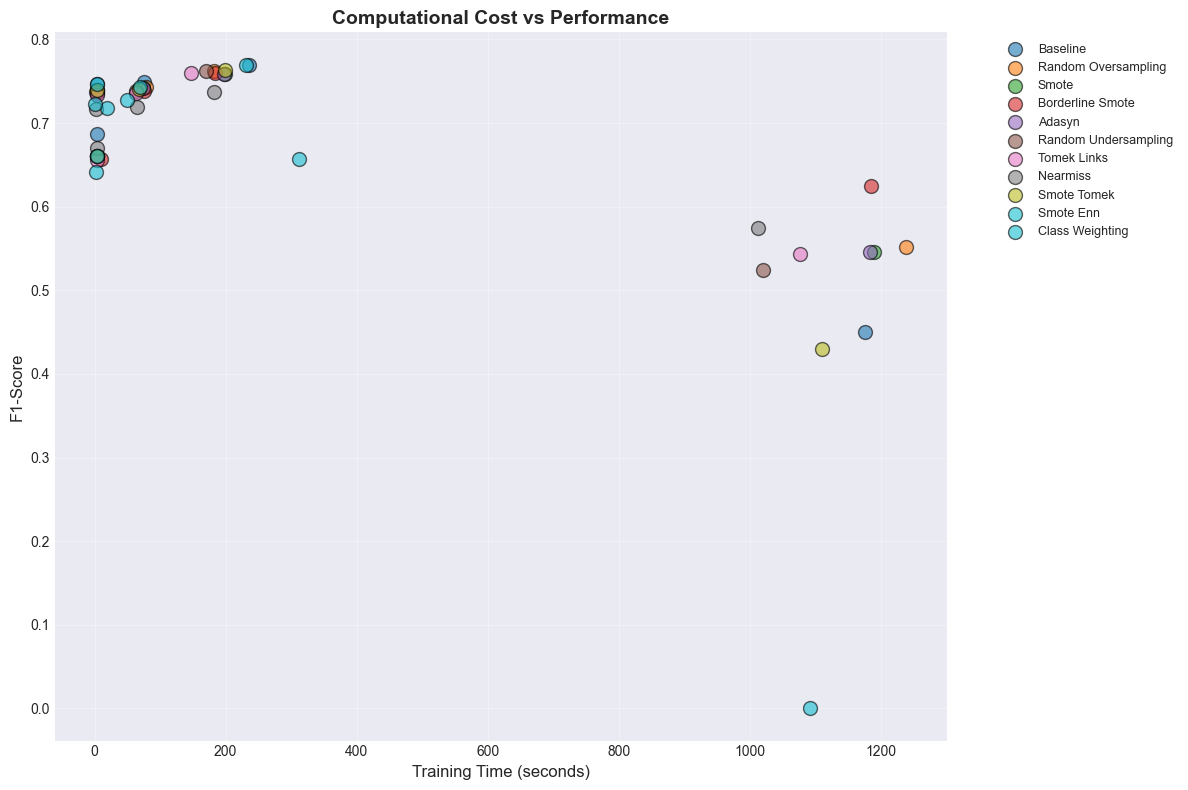

In [20]:
# Cell 18: Computational Cost Analysis
# Analyzing training time vs performance tradeoffs
# Scatter plot of time vs F1-score

print("Generating computational cost analysis...")

# Creating scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting each method with different color
methods_unique = successful_df['resampling_method'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(methods_unique)))

for i, method in enumerate(methods_unique):
    method_data = successful_df[successful_df['resampling_method'] == method]
    ax.scatter(method_data['training_time'], method_data['f1_score'],
              label=method.replace('_', ' ').title(), 
              s=100, alpha=0.6, color=colors[i], edgecolors='black')

# Formatting
ax.set_xlabel('Training Time (seconds)', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Computational Cost vs Performance', 
             fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Saving
cost_plot_path = FIGURE_OUTPUT / 'experiment_cost_analysis.png'
plt.savefig(cost_plot_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Cost analysis saved to {cost_plot_path}")

plt.show()

Generating method performance distributions...
Distribution plot saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\experiment_distributions.png


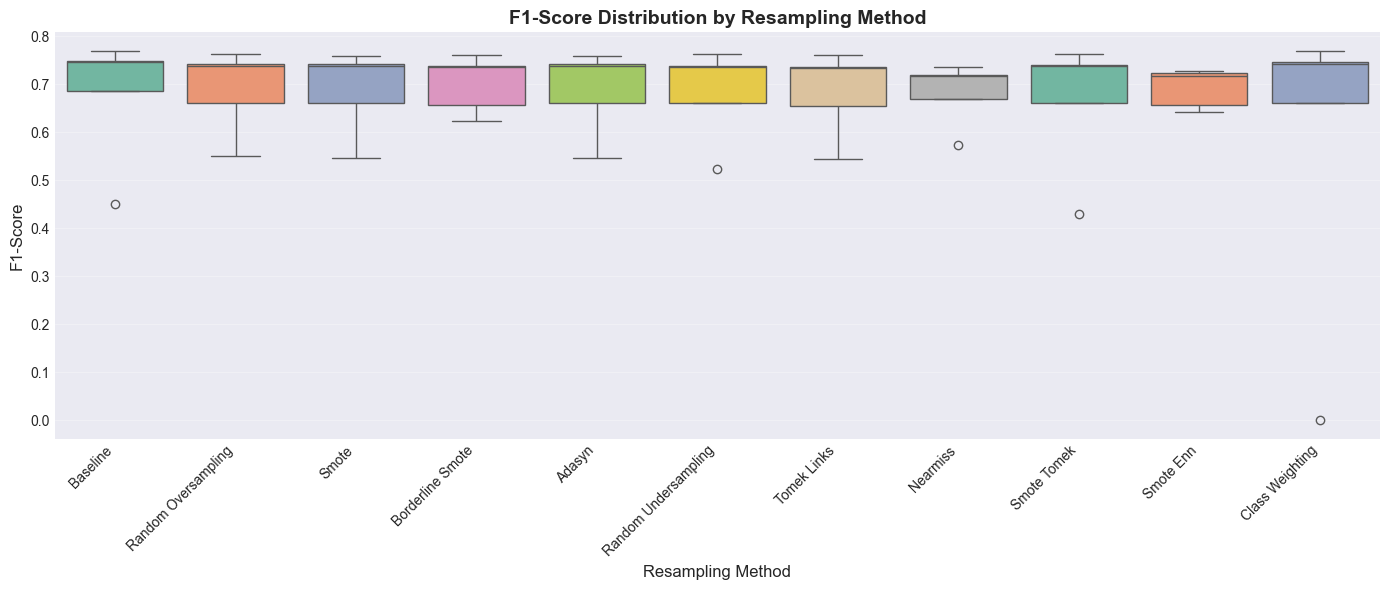

In [21]:
# Cell 19: Method Performance Distribution
# Visualizing performance distribution for each method
# Box plot showing F1-score distributions

print("Generating method performance distributions...")

# Creating box plot
fig, ax = plt.subplots(figsize=(14, 6))

# Preparing data
plot_data = successful_df[['resampling_method', 'f1_score']].copy()
plot_data['resampling_method'] = plot_data['resampling_method'].str.replace('_', ' ').str.title()

# Creating box plot
sns.boxplot(data=plot_data, x='resampling_method', y='f1_score', 
           palette='Set2', ax=ax)

# Formatting
ax.set_xlabel('Resampling Method', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('F1-Score Distribution by Resampling Method',
             fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Saving
dist_plot_path = FIGURE_OUTPUT / 'experiment_distributions.png'
plt.savefig(dist_plot_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Distribution plot saved to {dist_plot_path}")

plt.show()

In [22]:
# Cell 20: Saving Complete Results
# Persisting all experimental results
# CSV file with all 55 experiments

print("="*70)
print("SAVING EXPERIMENT RESULTS")
print("="*70)

# Saving full results
full_results_path = METRIC_OUTPUT / 'experiments' / 'full_experiment_results.csv'
full_results_path.parent.mkdir(parents=True, exist_ok=True)

successful_df.to_csv(full_results_path, index=False)
print(f"Full results saved to {full_results_path}")

# Saving summary statistics
summary_path = TABLE_OUTPUT / 'experiment_summary.csv'
method_performance.to_csv(summary_path, index=False)
print(f"Method summary saved to {summary_path}")

model_summary_path = TABLE_OUTPUT / 'model_summary.csv'
model_performance.to_csv(model_summary_path, index=False)
print(f"Model summary saved to {model_summary_path}")

# Saving top performers
top_path = TABLE_OUTPUT / 'top_configurations.csv'
top_performers.to_csv(top_path, index=False)
print(f"Top configurations saved to {top_path}")

print("\nAll results saved successfully")

SAVING EXPERIMENT RESULTS
Full results saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\metrics\experiments\full_experiment_results.csv
Method summary saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\tables\experiment_summary.csv
Model summary saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\tables\model_summary.csv
Top configurations saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\tables\top_configurations.csv

All results saved successfully


In [23]:
# Cell 21: Key Findings Summary
# Synthesizing main experimental findings

print("="*70)
print("KEY EXPERIMENTAL FINDINGS")
print("="*70)

print("\n1. BEST OVERALL CONFIGURATION:")
print(f"   Method: {best_config['resampling_method']}")
print(f"   Model: {best_config['model']}")
print(f"   F1-Score: {best_config['f1_score']:.4f}")
print(f"   Improvement over Baseline: +{improvement_pct:.2f}%")

print("\n2. BEST RESAMPLING METHOD (AVERAGE):")
print(f"   Method: {best_method['resampling_method']}")
print(f"   Mean F1: {best_method['f1_score_mean']:.4f}")
print(f"   Consistency: Std={best_method['f1_score_std']:.4f}")

print("\n3. BEST MODEL (AVERAGE):")
print(f"   Model: {best_model_overall['model']}")
print(f"   Mean F1: {best_model_overall['f1_score_mean']:.4f}")
print(f"   Avg Training Time: {best_model_overall['training_time_mean']:.2f}s")

print("\n4. PERFORMANCE RANGE:")
print(f"   Best F1: {successful_df['f1_score'].max():.4f}")
print(f"   Worst F1: {successful_df['f1_score'].min():.4f}")
print(f"   Range: {successful_df['f1_score'].max() - successful_df['f1_score'].min():.4f}")

print("\n5. COMPUTATIONAL EFFICIENCY:")
fastest_exp = successful_df.nsmallest(1, 'training_time').iloc[0]
slowest_exp = successful_df.nlargest(1, 'training_time').iloc[0]
print(f"   Fastest: {fastest_exp['resampling_method']} + {fastest_exp['model']}")
print(f"            ({fastest_exp['training_time']:.2f}s)")
print(f"   Slowest: {slowest_exp['resampling_method']} + {slowest_exp['model']}")
print(f"            ({slowest_exp['training_time']:.2f}s)")

print("\n6. STATISTICAL SIGNIFICANCE:")
sig_count = sum([r['significant'] for r in significance_results])
print(f"   Methods significantly better than baseline: {sig_count}/{len(significance_results)}")

print("\n7. METHOD CATEGORIES PERFORMANCE:")
oversample_methods = ['smote', 'borderline_smote', 'adasyn', 'random_oversampling']
undersample_methods = ['random_undersampling', 'tomek_links', 'nearmiss']
combo_methods = ['smote_tomek', 'smote_enn']

oversample_f1 = successful_df[successful_df['resampling_method'].isin(oversample_methods)]['f1_score'].mean()
undersample_f1 = successful_df[successful_df['resampling_method'].isin(undersample_methods)]['f1_score'].mean()
combo_f1 = successful_df[successful_df['resampling_method'].isin(combo_methods)]['f1_score'].mean()

print(f"   Oversampling Avg: {oversample_f1:.4f}")
print(f"   Undersampling Avg: {undersample_f1:.4f}")
print(f"   Combination Avg: {combo_f1:.4f}")

KEY EXPERIMENTAL FINDINGS

1. BEST OVERALL CONFIGURATION:
   Method: baseline
   Model: mlp
   F1-Score: 0.7701
   Improvement over Baseline: +0.00%

2. BEST RESAMPLING METHOD (AVERAGE):
   Method: borderline_smote
   Mean F1: 0.7032
   Consistency: Std=0.0591

3. BEST MODEL (AVERAGE):
   Model: mlp
   Mean F1: 0.7575
   Avg Training Time: 179.91s

4. PERFORMANCE RANGE:
   Best F1: 0.7701
   Worst F1: 0.0000
   Range: 0.7701

5. COMPUTATIONAL EFFICIENCY:
   Fastest: smote_enn + xgboost
            (1.18s)
   Slowest: random_oversampling + svm
            (1239.42s)

6. STATISTICAL SIGNIFICANCE:
   Methods significantly better than baseline: 0/5

7. METHOD CATEGORIES PERFORMANCE:
   Oversampling Avg: 0.6933
   Undersampling Avg: 0.6847
   Combination Avg: 0.6803
